# Lab 4 - Part D: Face detection with logistic regression
The goal of this part of the practical is to implement logistic regression for classifying faces and non-faces. 

**TODO:** This is a complete working bit of code. Your goals are to:
1. Look at the code and understand it
2. Investigate what happens as you increase the amount of training data - try 750, 1000, 1500, 2000, 3000, 4000 examples.  Does it generalize better?
3. Try learning with gradient descent with 4000 examples. What happens?
4. Convert this to a non-linear logistic regression algorithm by transforming the data before running the routine (see the '`transform`' method of the '`LogisticRegression`' class). Write a routine to transform each data point to a 500x1  vector by evaluating it against 500 radial basis functions.  

    The centers of these functions can be the first 500 data points.  You should experiment with the standard deviation, but somewhere in the range 1-100 should be a good start.
    
    **Note:** since this non-linear model will be largely the same as the linear version, you may want to create a sub-class that inherits from '`LogisticRegression`', and only overrides the '`transform`' method.

### Import modules

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.io import loadmat
from scipy.special import expit as sigmoid

from functions import LogisticRegressionNLL
from optimisation import SteepestDescent, NewtonMethod, optimise
from utils import add_bias, visualise_faces

# Create data loader

In [2]:
class DataLoader:
    def __init__(self, filename):
        self.data = loadmat(filename)
        self.training_images = self.data['x'].transpose(2, 0, 1).astype(np.float32) / 256
        self.training_labels = self.data['y'].squeeze()
        self.testing_images = self.data['xTest'].transpose(2, 0, 1).astype(np.float32) / 256
        self.testing_labels = self.data['yTest'].squeeze()

    def training(self, num_examples=None):
        return self.training_images[slice(num_examples)], self.training_labels[slice(num_examples)]

    def testing(self, num_examples=None):
        return self.testing_images[slice(num_examples)], self.testing_labels[slice(num_examples)]

# Define logistic regression model

In [3]:
class LogisticRegression:
    def __init__(self, dimensions):
        self.phi = add_bias(1e-4 * np.random.randn(dimensions, 1))

    def transform(self, image):
        return add_bias(image.flatten())

    def __call__(self, images):
        x = np.stack([self.transform(image) for image in images], axis=1)
        return sigmoid(self.phi.T @ x)

    def train(self, data, max_iterations, optimiser, tolerance=1e-8):
        images, labels = data
        x = np.stack([self.transform(image) for image in images], axis=1)
        phi_opt, _ = optimise(self.phi, tolerance, function=LogisticRegressionNLL(x, labels),
                              optimiser=optimiser, max_iterations=max_iterations)
        self.phi = phi_opt[-1]

# Load and inspect data

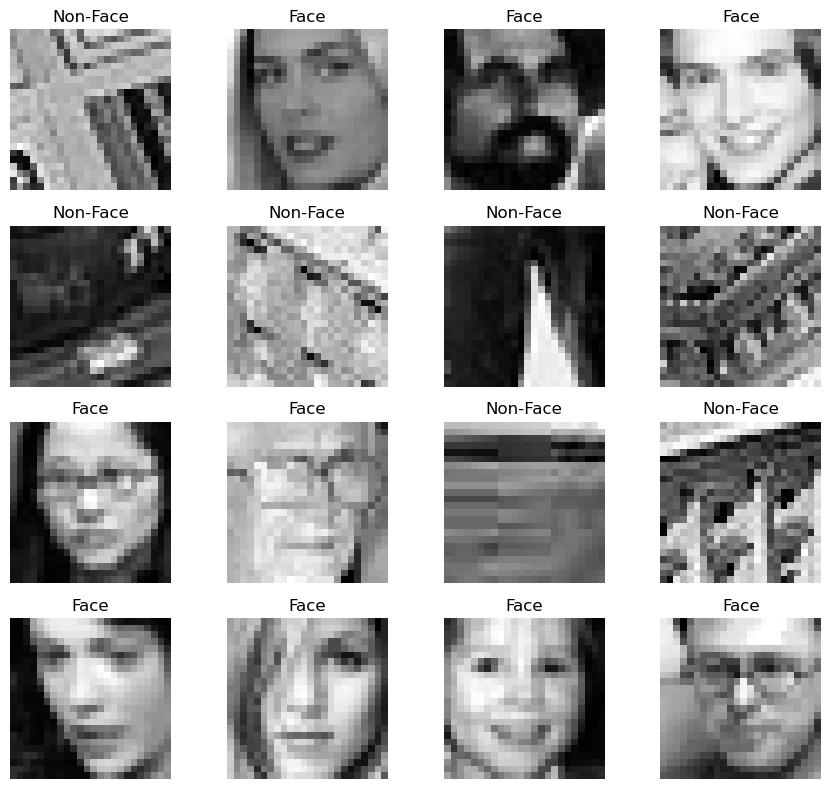

In [4]:
np.random.seed(2)
data = DataLoader('FaceDetectData.mat')

visualise_faces(data.training())

# Train the model
We define the model we are fitting to be logistic regression for 576-dimensional data, i.e. flattened vectors of the 24x24 pixel images. The model is trained using a subset of the training data, and its parameters are updated internally. You can see in the [previous section](#Define-logistic-regression-model) where we defined the model how this is implemented, and verify that it is just an abstraction of what we did in Parts B and C.

In [5]:
model = LogisticRegression(dimensions=24*24)

In [6]:
model.train(data.training(num_examples=600), max_iterations=50, optimiser=NewtonMethod)

Iteration    1, Function 436.32181846139156


# Inference and evaluation
Now that it has been trained, calling the model as a function on images will output the probability of that image being a face or a non-face. This is compared against the ground truth labels for accuracy, and can be visually verified also.

In [7]:
prediction = model(data.training_images) > 0.5
correct_prediction = prediction == data.training_labels
print('Training Data: Classified {:3.3f}% correct'.format(100 * correct_prediction.mean()))

Training Data: Classified 53.925% correct


Test Data: Classified 52.500% correct


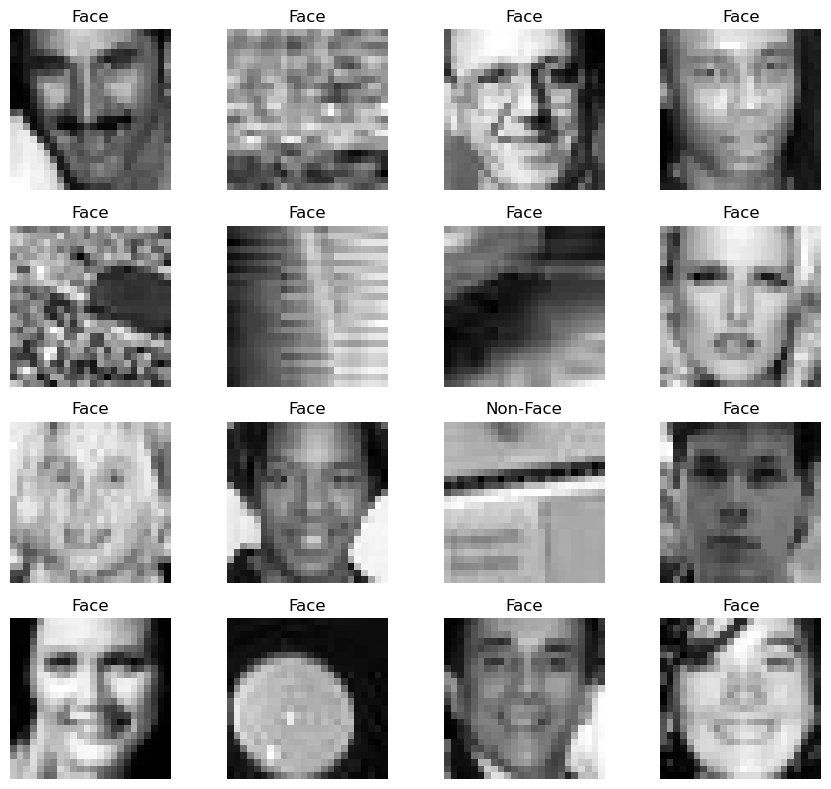

In [8]:
prediction = model(data.testing_images) > 0.5
correct_prediction = prediction == data.testing_labels
print('Test Data: Classified {:3.3f}% correct'.format(100 * correct_prediction.mean()))

visualise_faces((data.testing_images, prediction.squeeze()))